In [1]:
# 2018-10-09
# A. Pendleton
# Intersect the Final gene set with the novel gaps that are in Zoey
#    that were called by Feichen

In [2]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import sys
import numpy as np
import matplotlib.patches as patches
import gzip
import fileinput
import glob
from scipy import stats
import re
from matplotlib_venn import venn3, venn3_circles
from collections import OrderedDict


def count_lines(f):
    lineCount = 0
    with open(f, 'r') as f:
        for line in f:
            lineCount += 1
        return lineCount
def runCMD(cmd):
    val = subprocess.Popen(cmd, shell=True).wait()
    if val == 0:
        pass
    else:
        print ('command failed')
        print (cmd)
        sys.exit(1)
# TO REMOVE TOP AND RIGHT AXIS OF PLOTS
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
#Write PBS Script
def write_pbs_file(wkDir,cmdsFile,jobName, mem, jobCount):
    #write PBS file
    if '/scripts/' in wkDir:
        wkDir = wkDir.replace('/scripts/','')
    pbsFile = open(cmdsFile.replace('.cmds','.pbs'),'w')
    print('Writing pbs file: %s'% pbsFile)
    pbsFile.write('#!/bin/bash\n')
    pbsFile.write('#PBS -S /bin/bash\n')
    pbsFile.write('#PBS -V\n')
    pbsFile.write('#PBS -M ampend@med.umich.edu\n')
    pbsFile.write('#PBS -j oe\n')
    pbsFile.write('#PBS -N %s\n' % jobName)
    pbsFile.write('#PBS -o %s\n' % (wkDir + 'logs/'))
    pbsFile.write('#PBS -l pmem=%iG\n' % mem)
    pbsFile.write('#PBS -l nodes=1:ppn=1,qos=flux,walltime=100:00:00\n')
    pbsFile.write('##PBS -A medbsm_flux\n')
    pbsFile.write('##PBS -q flux\n')
    pbsFile.write('#PBS -A jmkidd_fluxod\n')
    pbsFile.write('#PBS -q fluxod\n')
    pbsFile.write('#PBS -t 1-%s\n' % jobCount)
    pbsFile.write('cd %s\n' % (wkDir))
    pbsFile.write('/home/ampend/links/kidd-lab/jmkidd-projects/scripts/perlUtils/run-by-id-log.pl %s %sBLAT_commands.logs $PBS_ARRAYID' % (cmdsFile,cmdsFile.replace('/scripts/','/logs/')))
    pbsFile.close()

# Define Inputs

### CREATE Input 1 = Zoey Exon BED file

##### Extract the exon coordinates from the transdecoder gff3 file which gives us exon positions for ALL genes. 
However, we only want the genes that made it into the final set (N=42,911 genes).


So, you'll need to read in the final gene ID list first, then extract exon positions only for the genes that made it into the final list.

In [3]:
finalDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/'

#Final list of 42,911 genes from Zoey annotations that went through annotations 
FinalGeneList = []
finalGeneIDFile = finalDir + 'FinalGenes_IDs.txt'

for line in open(finalGeneIDFile,'r'):
    line=line.rstrip()
    gene = line
    FinalGeneList.append(gene)

print('Added %i IDs from the final gene list' % len(FinalGeneList))

Added 42911 IDs from the final gene list


In [4]:
gffFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.genome.gff3'

#Use grep to only get the exons
cmd = 'grep "exon" %s > %s.exonsOnly' % (gffFile,gffFile) 
print(cmd)
runCMD(cmd)

grep "exon" /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.genome.gff3 > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.genome.gff3.exonsOnly


### Only need to generate the exon bed file once. 
## TAKES A LONG TIME
### So the below cell is hashed out and a second cell will read the bed file and save everything to the proper array

In [18]:
"""gffFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.genome.gff3'

exonBedfile = finalDir + 'Zoey_FinalGenes_exons.bed'
exonBedFile = open(exonBedfile,'w')

parentGenes = []
lineCount = 0

for line in open(gffFile + '.exonsOnly','r'):
    line=line.rstrip().split('\t')
    if len(line) < 2:
        continue

    #only interested in exons
    if 'exon' not in line[2]:
        continue

    chrom,start,end = line[0],int(line[3])-1,int(line[4])
    geneID = line[8].split(';')[0].replace('ID=','')
    parentGene = line[8].split(';')[1].replace('Parent=','')
    
    #We only want the final genes. Some genes in this gff file did not make it through 
    #   post-processing filtration steps
    if parentGene not in FinalGeneList:
        continue
    lineCount+=1 

    parentGenes.append(parentGene) #keep track of the genes that we end up adding to see if we are missing any later
    exonBedFile.write('%s\t%i\t%i\t%s\n' % (chrom,start,end,geneID))
    
    if lineCount % 10000 == 0:
        print(lineCount)
    #if lineCount > 10000: # for testing
        #break
exonBedFile.close()

print('Done with %i exons' % lineCount )
unique_parentGenes = set(parentGenes)
print('From %i genes' % len(set(parentGenes)))"""

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
Done with 206013 exons
From 42911 genes


In [19]:
parentGenes = []

for line in open(exonBedfile,'r'):
    line=line.rstrip().split('\t')
    chrom,start,end = line[0],int(line[1]),int(line[2])
    geneID = line[3]
    #parentID = geneID.rsplit('.',1)[0]
    parentID = geneID.split('.exon')[0]
    parentGenes.append(parentID)
    

print('%i exons added' % len(parentGenes))
unique_parentGenes = set(parentGenes)
print('From %i genes' % len(set(parentGenes)))

206013 exons added
From 42911 genes


In [21]:
#Check that we didn't miss any exon coordinates
missing = []

for gene in FinalGeneList:
    if gene not in unique_parentGenes:
        #print('ERROR: For some reason we are missing gene: ', gene)
        missing.append(gene)
print('Missing %i genes' % len(missing))

Missing 0 genes


### Input 2 = Feichen Gap BED file

In [23]:
gapBedfile = finalDir + 'Intersect_FeichenGaps/' + 'MergedGaps_CfLiftoverToZoey_And_NovelZoeyCoord.bed'


In [43]:
##########################################################################################
##########################################################################################
##########################################################################################

# Intersect the final exons with the novel gaps

In [24]:
intersectOutfile = finalDir + 'Intersect_FeichenGaps/Intersect_ZoeyNovelGaps_with_ZoeyFinalGeneExons.txt'

cmd = 'bedtools intersect -wo -a %s -b %s > %s' % (gapBedfile,exonBedfile,intersectOutfile)
print(cmd)
runCMD(cmd)

bedtools intersect -wo -a /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Intersect_FeichenGaps/MergedGaps_CfLiftoverToZoey_And_NovelZoeyCoord.bed -b /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Zoey_FinalGenes_exons.bed > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Intersect_FeichenGaps/Intersect_ZoeyNovelGaps_with_ZoeyFinalGeneExons.txt


In [43]:
##########################################################################################
##########################################################################################
##########################################################################################

# Read in the GC content pvalues

In [25]:
GCbed = '/nfs/turbo/jmkiddscr/feichens-projects/Zoey_pacbio/4_Post_analysis/QuicKmer/ROI_index_in_bianry.bed'

GCDict_pval = {}

for line in open(GCbed,'r'):
    line=line.rstrip().split('\t')
    ID = line[0] + ':' + line[1] + '-' + line[2]
    GCDict_pval[ID] = float(line[5])
    
print('added in GC pvalues for %i windows' % len(GCDict_pval.keys()))

added in GC pvalues for 13839 windows


### Get the pvalues for those windows that intersect with exons

In [26]:
added = []
couldntbeadded = []
pvalues = [] #for plotting the pvalues later
gapLiftPvalues, novelZoeyPvalues = [], [] 

for line in open(intersectOutfile,'r'):
    line=line.rstrip().split('\t')
    ID = line[0] + ':' + line[1] + '-' + line[2]
    
    #only add the gap once for histogram plotting later on
    if ID in added:
        continue
        
    added.append(ID)
    
    #Unfortunately, kmers could only be called in some of the windows, so not every
    #   one will have a pvalue associated with it
    if ID in GCDict_pval.keys():
        pvalue = GCDict_pval[ID]
        pvalues.append(pvalue)
        if '_GapLift' in line[3]:
            gapLiftPvalues.append(pvalue)
        if 'NovelZoey' in line[3]:
            novelZoeyPvalues.append(pvalue)

    else:
        couldntbeadded.append(ID)

print('In total %i gap windows have intersects with at least one exon\n' % len(added))
print('Got the pvalues for %i windows that intersected with exons:' % len(pvalues))
print('%i were the lifted over gaps' % len(gapLiftPvalues))
print('%i were with novel zoey gaps\n' % len(novelZoeyPvalues))
print('No pvalues were available for %i windows that intersected with exons' % len(couldntbeadded))


In total 3876 gap windows have intersects with at least one exon

Got the pvalues for 3422 windows that intersected with exons:
3422 were the lifted over gaps
0 were with novel zoey gaps

No pvalues were available for 454 windows that intersected with exons


### P-value histogram --- All intersects regardless of gap type

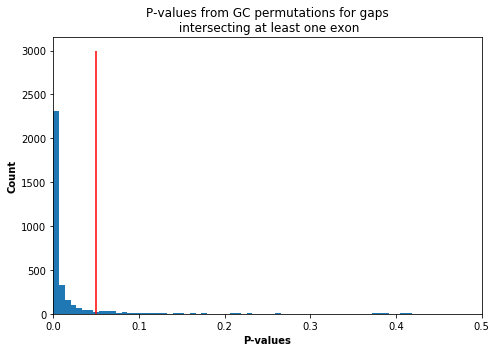

In [27]:
plt.figure(figsize=(7,5))

plt.hist(pvalues,bins=150)
plt.xlim(0,0.5)
plt.vlines(ymin=0,ymax=3000,x=0.05,color='red')
#Add labels and title
plt.title('P-values from GC permutations for gaps\n intersecting at least one exon')
plt.xlabel('P-values',fontweight='bold')
plt.ylabel('Count',fontweight='bold')
plt.tight_layout()
plt.show()

### P-value histogram --- Only Gap Liftover type

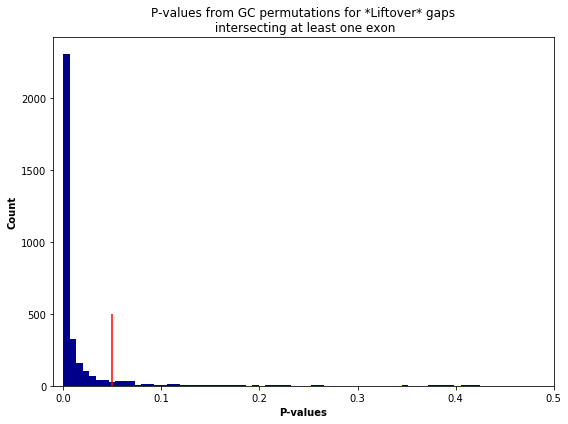

In [90]:
plt.figure(figsize=(8,6))

plt.hist(pvalues,bins=150,color='darkblue')
plt.xlim(-0.01,0.5)
plt.vlines(ymin=0,ymax=500,x=0.05,color='red')
#Add labels and title
plt.title('P-values from GC permutations for *Liftover* gaps\n intersecting at least one exon')
plt.xlabel('P-values',fontweight='bold')
plt.ylabel('Count',fontweight='bold')
plt.tight_layout()
plt.show()

In [28]:
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################


# Assessing exon number bias for those in novel regions
### We hypothesize that the novel exons are mostly in the beginning/ends of genes due to GC bias

#### Store the N'th exon number for every gene

In [33]:
exonCountDict = {}

for line in open(exonBedfile, 'r'):
    line=line.rstrip().split('\t')
    exonID = line[3]
    exonNum = int(exonID.split('.exon')[1]) #get the exon number for this bed entry
    geneID = exonID.split('.exon')[0] #gene identifier

    if geneID in exonCountDict.keys():
        if exonNum > exonCountDict[geneID]:
            exonCountDict[geneID] = exonNum
        else:
            continue
    else:
        exonCountDict[geneID] = exonNum
print('Added exon counts for the %i genes' % len(exonCountDict.keys()))

Added exon counts for the 42911 genes


#### Store the N'th exon number for every gene

In [370]:
########################################################################################
def parse_real_intersect(Dict,intersectFile): 

    geneLengths = [] #keeping track of gene lengths
    exonNums = []
    genes = []

    #Reading the intersect file results
    for line in open(intersectFile,'r'):
        line = line.rstrip().split('\t') #removing extraneous whitespace characters
        #Example exonID = Gene.23056::chr1.g10665.i1::g.23056::m.23056.exon9, exonNum = 9
        exonID = line[7]
        exonNum = int(exonID.split('.exon')[1])
        geneID = exonID.split('.exon')[0]
        
        #Gene length
        geneLength = lengthDict[geneID]
        if geneID not in genes:
            genes.append(geneID)
            #Only add gene length if the gene lenght hasn't already been added
            geneLengths.append(geneLength)
            
        #Store globally exonnums and genes
        exonNums.append(exonNum)
        
        exonMax = exonCountDict[geneID]
        if exonNum not in Dict.keys():
            Dict[exonNum] = []
            
        Dict[exonNum].append([exonNum,exonMax,exonID,geneLength])
            
    return Dict, genes, geneLengths, exonNums
########################################################################################
def parse_shuffle_intersect(Dict,intersectFile): 

    geneLengths = [] #keeping track of gene lengths
    exonNums = []
    genes = []

    #Reading the intersect file results
    for line in open(intersectFile,'r'):
        line = line.rstrip().split('\t') #removing extraneous whitespace characters
        #Example exonID = Gene.23056::chr1.g10665.i1::g.23056::m.23056.exon9, exonNum = 9
        exonID = line[3]
        exonNum = int(exonID.split('.exon')[1])
        geneID = exonID.split('.exon')[0]
        
        #Gene length
        geneLength = lengthDict[geneID]
        if geneID not in genes:
            genes.append(geneID)
            #Only add gene length if the gene lenght hasn't already been added
            geneLengths.append(geneLength)
            
        #Store globally exonnums and genes
        exonNums.append(exonNum)
        
        exonMax = exonCountDict[geneID]
        if exonNum not in Dict.keys():
            Dict[exonNum] = []
            
        Dict[exonNum].append([exonNum,exonMax,exonID,geneLength])
            
    return Dict, genes, geneLengths, exonNums

# REAL DATA

In [381]:
intersectFile = finalDir + 'Intersect_FeichenGaps/Intersect_ZoeyNovelGaps_with_ZoeyFinalGeneExons.txt'

intersectingExonNumberDict = {}
dontQualify = 0
real_singleExon,real_twoExon = 0,0
real_genes, real_geneLengths = [], []
real_total_geneLengths = []

#### PARSE INTERSECT FILE ####
Dict = {}
Dict, genes, geneLengths, exonNums = parse_real_intersect(Dict, intersectFile)


#### *FRACTION* OF EXONS INTERSECTING GAPS ####    
possibleExons = totalExonCountInZoeyFile
real_intersectingExons = count_lines(intersectFile)
real_fractionIntersecting = real_intersectingExons/float(possibleExons)


#### GENE LENGTH ####    
for l in geneLengths:
    real_total_geneLengths.append(geneLength)
#Calculate average gene length and store globally 
real_averageGeneLengths = np.mean(geneLengths)


#### EXON POSITIONS RELATIVE TO MAX EXON COUNT ####
#Count for each possibility: Exon1,Exon2,Exon3,N-2,N-1,N
real_exon1,real_exon2,real_exon3,real_n2,real_n1,real_n = [], [], [], [], [], []
real_prop_exon1,real_prop_exon2,real_prop_exon3,real_prop_n2,real_prop_n1,real_prop_n = [], [], [], [], [], []


singleExon,twoExon = 0,0
passing = 0
for exonN in Dict.keys():
    for e in Dict[exonN]:
        #How many exons are possible?
        exonMax = e[1]

        #Skip the single exons
        if exonMax == 1:
            singleExon+=1
            continue
        if exonMax == 2:
            twoExon+=1
            continue

        passing += 1
        #Get the exon number that intersects
        exonNumIntersecting = int(e[2].split('.exon')[1])

        #For intersecting exons 1-3
        if exonNumIntersecting == 1:
            exon1.append([exonID,exonMax])
            continue
        if exonNumIntersecting == 2:
            exon2.append([exonID,exonMax])
            continue
        if exonNumIntersecting == 3:
            exon3.append([exonID,exonMax])
            continue

        #For those longer
        distanceFromLastExon = exonMax - exonNumIntersecting
        if distanceFromLastExon == 0:
            n.append([exonID,exonMax])
        if distanceFromLastExon == 1:
            n1.append([exonID,exonMax]) 
        if distanceFromLastExon == 2:
            n2.append([exonID,exonMax])

    #Total
    real_exon1.append(len(exon1))
    real_prop_exon1.append(len(exon1)/passing)
    real_exon2.append(len(exon2))
    real_prop_exon2.append(len(exon2)/passing)
    real_exon3.append(len(exon3))
    real_prop_exon3.append(len(exon3)/passing)
    real_n2.append(len(n2))
    real_prop_n2.append(len(n2)/passing)
    real_n1.append(len(n1))
    real_prop_n1.append(len(n1)/passing)
    real_n.append(len(n))
    real_prop_n.append(len(n)/passing)



#### SINGLE AND TWO EXON GENES ####
#keeping track of global single and 2 exon gene counts
real_twoExon = (lessthanthreeexons/float(real_intersectingExons))


print('%i gene models that intersect with novel regions dont qualify (less than three exons)' % dontQualify)        
print('Real single exons = ', singleExon)
real_singleExon = (singleExon/float(real_intersectingExons))
print('    as a proportion of total intersecting exons = ', real_singleExon)

print('Real two exons = ', twoExon)
real_twoExon = twoExon/float(real_total_exonIntersectCounts)
print('    as a proportion of total intersecting exons = ', real_twoExon )


print('\nAverage REAL gene length = ', real_averageGeneLengths)
 

0 gene models that intersect with novel regions dont qualify (less than three exons)
Real single exons =  1352
    as a proportion of total intersecting exons =  0.25337331334332835
Real two exons =  352
    as a proportion of total intersecting exons =  0.06596701649175413

Average REAL gene length =  39900.5079221


# Plotting by exon position

exon 1, exon 2, exon 3, n-2, n-1, n
2885.0 658.166666667 653.0 292.0 331.0 1250.0


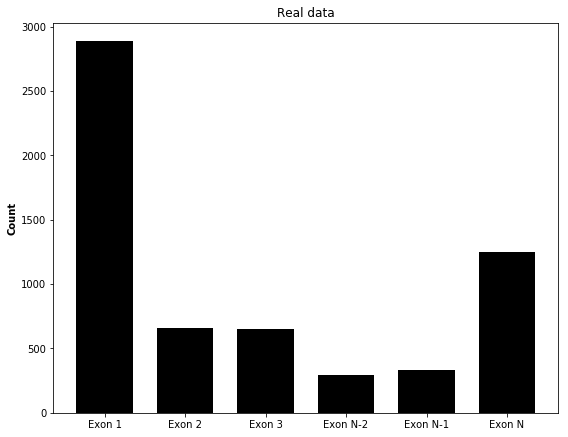

In [372]:
real_e1 = int(np.mean(real_exon1))
real_e2 = int(np.mean(real_exon2))
real_e3 = int(np.mean(real_exon3)) 
real_n2 = int(np.mean(real_n2))
real_n1 = int(np.mean(real_n1))
real_n = int(np.mean(real_n))

print('exon 1, exon 2, exon 3, n-2, n-1, n')
print(np.mean(real_exon1),np.mean(real_exon2),np.mean(real_exon3),np.mean(real_n2),np.mean(real_n1),np.mean(real_n))

xs = ['Exon 1','Exon 2','Exon 3','Exon N-2','Exon N-1','Exon N']
ys = [real_e1, real_e2, real_e3, real_n2, real_n1, real_n]
pos = [0,1,2,3,4,5]
#labels = xs

#fig, ax = plt.subplots()
plt.figure(figsize=(8, 6))  # width:20, height:3

names, ticks = [], []
for p in range(0,len(pos)):
    l = xs[p]
    _ = plt.bar(p,int(ys[p]),width = 0.7,align='center',color='black',label=l)
    names.append(xs[p])
    ticks.append(p)

_ =plt.xticks(ticks,names,fontsize=10)
#_ = plt.title('Exon Count for gene models intersecting novel ROI',fontweight='bold')
_ = plt.ylabel('Count',fontweight='bold')
plt.tight_layout()
plt.title('Real data')
plt.savefig(permDir + 'plots/RealData_exonposition.pdf')
plt.show()

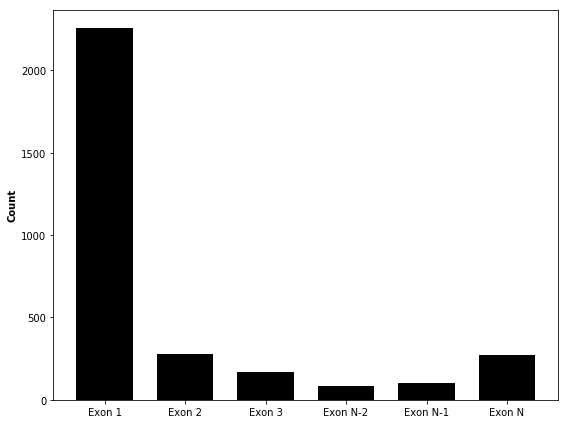

In [184]:
#labels, ys = zip(*countArray)
#xs = np.arange(len(labels)) 

xs = ['Exon 1','Exon 2','Exon 3','Exon N-2','Exon N-1','Exon N']
ys = [2255,280,168,81,102,272]
pos = [0,1,2,3,4,5]
#labels = xs

#fig, ax = plt.subplots()
plt.figure(figsize=(8, 6))  # width:20, height:3

names, ticks = [], []
for p in range(0,len(pos)):
    l = xs[p]
    _ = plt.bar(p,int(ys[p]),width = 0.7,align='center',color='black',label=l)
    names.append(xs[p])
    ticks.append(p)

_ =plt.xticks(ticks,names,fontsize=10)
#_ = plt.title('Exon Count for gene models intersecting novel ROI',fontweight='bold')
_ = plt.ylabel('Count',fontweight='bold')
plt.tight_layout()
plt.savefig('/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Intersect_FeichenGaps/plots/ExonIntersectCounts.pdf')
plt.show()

# How about when only one exon is added

In [163]:
Dict = {}

for line in open(intersectOutfile,'r'):
    line = line.rstrip().split('\t')
    
    #Determine what the max number of exons for this gene is
    geneID = line[7].split('.exon')[0]
    exonMax = exonCountDict[geneID]
    
    if geneID not in Dict.keys():
        Dict[geneID] = {}
        Dict[geneID]['exonMax'] = exonMax
        Dict[geneID]['intersectingnovelregions'] = []
        
    Dict[geneID]['intersectingnovelregions'].append(line[7])

In [169]:
print(len(Dict.keys()))
for key in Dict.keys():
    print(key)
    break
print(Dict['Gene.52430::chr10.g4190.i1::g.52430::m.52430'])

4418
Gene.52430::chr10.g4190.i1::g.52430::m.52430
{'exonMax': 15, 'intersectingnovelregions': ['Gene.52430::chr10.g4190.i1::g.52430::m.52430.exon1']}


In [173]:
intersectingExonNumberDict2 = {}
dontQualify = 0

for geneID in Dict.keys():
    if len(Dict[geneID]['intersectingnovelregions']) > 1:
        continue
    exonMax = int(Dict[geneID]['exonMax'])
    
    #Skip single exon genes
    if exonMax < 3:
        dontQualify+=1
        continue
    
    exonID = Dict[geneID]['intersectingnovelregions']
    #Get which exon intersected with the novel region from the bedfile
    for e in exonID:
        exonNumIntersecting = int(e.split('.exon')[1])
    
    #Now store positional information for each exon
    #If the exon is the first exon, simple, store it in key == 1
    if exonNumIntersecting <= 3:
        if exonNumIntersecting not in intersectingExonNumberDict2.keys():
            intersectingExonNumberDict2[exonNumIntersecting] = []
        intersectingExonNumberDict2[exonNumIntersecting].append([exonID,exonMax])
        continue
    
    else:
        #Distance from the end
        distanceFromLastExon = exonMax - exonNumIntersecting
        if distanceFromLastExon == 0:
            exonNumIntersecting = 'N'
        if distanceFromLastExon == 1:
            exonNumIntersecting = 'N-1'  
        if distanceFromLastExon == 2:
            exonNumIntersecting = 'N-2'
        if distanceFromLastExon > 2:
            exonNumIntersecting = 'Middle Exon'
        if exonNumIntersecting not in intersectingExonNumberDict2.keys():
            intersectingExonNumberDict2[exonNumIntersecting] = []
        intersectingExonNumberDict2[exonNumIntersecting].append([exonID,exonMax])
print('%i gene models that intersect with novel regions dont qualify (less than three exons)' % dontQualify)        
  
    
countArray2 = []
for count in intersectingExonNumberDict2.keys():
    if 'Middle' not in str(count):
        countArray2.append(['Exon ' + str(count),len(intersectingExonNumberDict2[count])])
    else:
        
        countArray2.append([str(count),len(intersectingExonNumberDict2[count])])
        
print(countArray2)
        
    

1543 gene models that intersect with novel regions dont qualify (less than three exons)
[['Exon 3', 64], ['Exon 1', 1931], ['Exon 2', 85], ['Exon N', 139], ['Middle Exon', 97], ['Exon N-2', 13], ['Exon N-1', 25]]


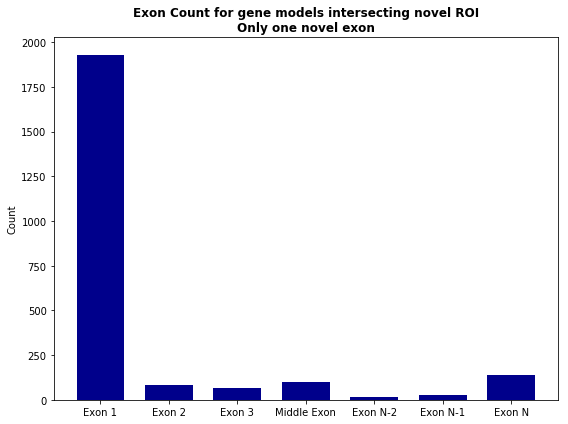

In [177]:
#labels, ys = zip(*countArray)
#xs = np.arange(len(labels)) 

xs = ['Exon 1','Exon 2','Exon 3','Middle Exon','Exon N-2','Exon N-1','Exon N']
ys = [1931,85,64,97,13,25,139]
pos = [0,1,2,3,4,5,6]
#labels = xs

#fig, ax = plt.subplots()
plt.figure(figsize=(8, 6))  # width:20, height:3

names, ticks = [], []
for p in range(0,len(pos)):
    l = xs[p]
    _ = plt.bar(p,int(ys[p]),width = 0.7,align='center',color='darkblue',label=l)
    names.append(xs[p])
    ticks.append(p)

_ =plt.xticks(ticks,names,fontsize=10)
_ = plt.title('Exon Count for gene models intersecting novel ROI\nOnly one novel exon',fontweight='bold')
_ = plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [185]:
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################

# Permutations

In [373]:
def get_all_gene_lengths(bedfile):
    lengthDict = {}
    for line in open(bedfile,'r'):
        line=line.rstrip().split('\t')
        length = int(line[2])-int(line[1])
        geneID = line[3].split(';')[0]
        lengthDict[geneID] = length
    return lengthDict
########################################################################################################
def get_chromosomes_to_analyse():
    chroms = []
    for i in range(1,39):
        chroms.append('chr' + str(i))
    chroms.append('chrX')
    return chroms

########################################################################################################
def do_intersects(a,b,outfile):
    cmd = 'bedtools intersect -wo -a %s -b %s > %s' % (a, b, outfile)
    runCMD(cmd)




In [278]:
#Get lengths of all genes
zoeyFullLengthGeneBed = finalDir + 'Zoey_FinalGenes.12.bed'
lengthDict = get_all_gene_lengths(zoeyFullLengthGeneBed)

#Determine the chromosomes to analyze
chroms = get_chromosomes_to_analyse() #Chromosomes 1-38 + chrX


In [374]:
#Write all xpclr sweeps to a output bedfile to be shuffled below
finalGeneDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/'
gapDir = finalGeneDir + 'Intersect_FeichenGaps/'

#make directory for the permutations
permDir = gapDir + 'permutations/'
cmd = 'mkdir -p %s' % permDir
runCMD(cmd)

#Gap file
novel_gapBedFile = gapDir + 'MergedGaps_CfLiftoverToZoey_And_NovelZoeyCoord.bed'

#Inputs
ZoeyGapBedFile = '~/links/kidd-lab/genomes/zoey/assemblies/2.3/gaps/zoey.2.3.gaps.bed'
ZoeyGenome = gapDir + 'Zoey2.3_AutosomesOnly.genome'
ZoeyGeneBedFile = finalGeneDir + 'Zoey_FinalGenes_exons_chr1-38_chrX.bed' #Only genes on chr1-38,chrX (no CTG or scaffold genes)


#### REAL ######
# HOW MANY EXONS INTERSECT WITH GAPS
real_possibleExons = count_lines(ZoeyGeneBedFile)
real_intersectingExons = count_lines(gapDir + 'Intersect_ZoeyNovelGaps_with_ZoeyFinalGeneExons.txt')
real_fractionIntersecting = real_intersectingExons/float(real_possibleExons)
print('Real fraction of exons intersecting novel gaps = ', real_fractionIntersecting)


#### PERM ######
#Keep track across all 1000 permutations gene counts, lengths, etc
perm_total_exonIntersectCounts  = []
perm_total_fractionExonIntersecting = []
perm_total_geneLengths, perm_averageGeneLengths = [], []
#number of exons in each possible position
perm_exon1,perm_exon2,perm_exon3,perm_n2,perm_n1,perm_n = [],[],[],[],[],[]
perm_prop_exon1,perm_prop_exon2,perm_prop_exon3,perm_prop_n2,perm_prop_n1,perm_prop_n = [],[],[],[],[],[]
#number of single exon genes, number of genes with 2 exons
perm_singleExon,perm_lessthanthreeexons = [], []

fractionIntersectingGaps = []


for i in range(0,1000): #1000 permutations
    #shuffle the coordinates
    shuffledFile = permDir + 'shuffle_%i.bed' % i
    cmd = 'bedtools shuffle -excl %s -i %s -g %s > %s' % (ZoeyGapBedFile, ZoeyGeneBedFile, ZoeyGenome, shuffledFile)
    #runCMD(cmd)
    
    #Intersect shuffled Zoey genes with gaps
    outfile = permDir + 'intersect_zoeygenes_withgaps_%i.txt' % (i)
    #do_intersects(shuffledFile,novel_gapBedFile,outfile)
    
    
    #### PARSE INTERSECT FILE ####
    Dict = {}
    Dict, genes, geneLengths, exonNums = parse_shuffle_intersect(Dict, outfile)

    
    #### *FRACTION* OF EXONS INTERSECTING GAPS ####    
    possibleExons = totalExonCountInZoeyFile
    perm_intersectingExons = count_lines(outfile)
    perm_fractionIntersecting = perm_intersectingExons/float(possibleExons)
    #print('perm %i fraction: %f' % (i,perm_fractionIntersecting))
    perm_total_fractionExonIntersecting.append(perm_fractionIntersecting)
    
    #### NUMBER OF EXONS INTERSECTING GAPS ####
    #Keep track globally of total number of intersects with exons there were
    perm_total_exonIntersectCounts.append(count_lines(outfile)) 
   

    #### GENE LENGTH ####    
    for l in geneLengths:
        perm_total_geneLengths.append(geneLength)
    #Calculate average gene length and store globally 
    perm_averageGeneLengths.append(np.mean(geneLengths))
    
    
    #### EXON POSITIONS RELATIVE TO MAX EXON COUNT ####
    #Count for each possibility: Exon1,Exon2,Exon3,N-2,N-1,N
    exon1,exon2,exon3,n2,n1,n = [], [], [], [], [], []
    singleExon,lessthanthreeexons = 0,0
    passing = 0
    for exonN in Dict.keys():
        for e in Dict[exonN]:
            #How many exons are possible?
            exonMax = e[1]

            #Skip the single exons
            if exonMax == 1:
                singleExon+=1
                continue
            if exonMax < 3:
                lessthanthreeexons+=1
                continue
                
            passing += 1
            #Get the exon number that intersects
            exonNumIntersecting = int(e[2].split('.exon')[1])
            
            #For intersecting exons 1-3
            if exonNumIntersecting == 1:
                exon1.append([exonID,exonMax])
                continue
            if exonNumIntersecting == 2:
                exon2.append([exonID,exonMax])
                continue
            if exonNumIntersecting == 3:
                exon3.append([exonID,exonMax])
                continue
            
            #For those longer
            distanceFromLastExon = exonMax - exonNumIntersecting
            if distanceFromLastExon == 0:
                n.append([exonID,exonMax])
            if distanceFromLastExon == 1:
                n1.append([exonID,exonMax]) 
            if distanceFromLastExon == 2:
                n2.append([exonID,exonMax])
        
        #Total
        perm_exon1.append(len(exon1))
        perm_prop_exon1.append(len(exon1)/passing)
        perm_exon2.append(len(exon2))
        perm_prop_exon2.append(len(exon2)/passing)
        perm_exon3.append(len(exon3))
        perm_prop_exon3.append(len(exon3)/passing)
        perm_n2.append(len(n2))
        perm_prop_n2.append(len(n2)/passing)
        perm_n1.append(len(n1))
        perm_prop_n1.append(len(n1)/passing)
        perm_n.append(len(n))
        perm_prop_n.append(len(n)/passing)

    
    
    #### SINGLE AND TWO EXON GENES ####
    #keeping track of global single and 2 exon gene counts
    perm_singleExon.append(singleExon/float(perm_intersectingExons))
    perm_lessthanthreeexons.append(lessthanthreeexons/float(perm_intersectingExons))
    
    
    if i > 1000:
        break
    
print('Done') 

Real fraction of exons intersecting novel gaps =  0.026052270541307203
Done


## Histogram of the proportion of exons intersecting a gap regardless of max exon count

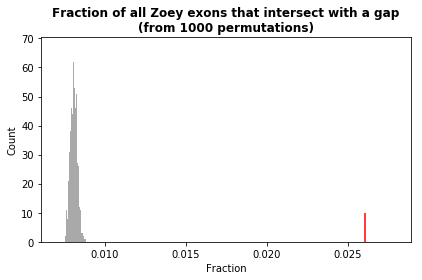

In [407]:
plt.hist(perm_total_fractionExonIntersecting,bins=50,color='darkgrey')
plt.xlim(real_fractionIntersecting - 0.02,max(perm_total_fractionExonIntersecting)+0.02)
plt.vlines(real_fractionIntersecting,0,10,color='red')
plt.title('Fraction of all Zoey exons that intersect with a gap\n(from 1000 permutations)',fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Fraction')
plt.tight_layout()
plt.show()


## Histogram of the length of genes intersecting gap (genes can only be counted once even if they intersect with multiple gaps)

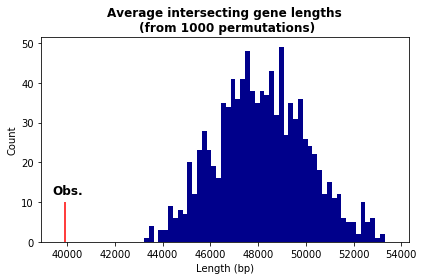

In [409]:
plt.hist(perm_averageGeneLengths,bins=50,color='darkblue')
plt.xlim(real_averageGeneLengths - 1000,max(perm_averageGeneLengths)+1000)
plt.vlines(real_averageGeneLengths,0,10,color='red')
plt.title('Average intersecting gene lengths\n (from 1000 permutations)',fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Length (bp)')
plt.text(real_averageGeneLengths-500, 12, 'Obs.', fontsize=12,fontweight='bold')
plt.tight_layout()
plt.show()


## Total number of intersects (can count doubles)

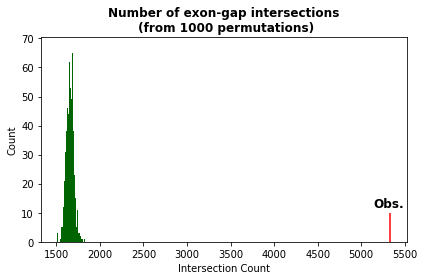

In [410]:
plt.hist(perm_total_exonIntersectCounts,bins=50,color='darkgreen')
#plt.xlim(real_fractionIntersecting - 0.02,max(perm_total_fractionExonIntersecting)+0.02)
plt.vlines(real_total_exonIntersectCounts,0,10,color='red')
plt.title('Number of exon-gap intersections\n (from 1000 permutations)',fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Intersection Count')
plt.text(real_total_exonIntersectCounts-200, 12, 'Obs.', fontsize=12,fontweight='bold')
plt.tight_layout()
plt.show()


## Total number of single exon intersects 

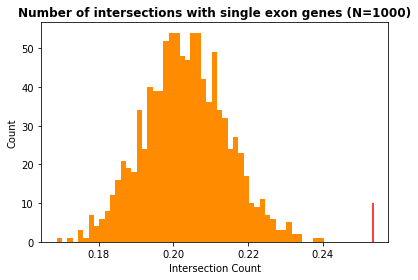

In [412]:
plt.hist(perm_singleExon,bins=50,color='darkorange')
#plt.xlim(real_fractionIntersecting - 0.02,max(perm_total_fractionExonIntersecting)+0.02)
plt.vlines(real_singleExon,0,10,color='red')
plt.title('Number of intersections with single exon genes (N=1000)',fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Intersection Count')
plt.text(real_singleExon-200, 12, 'Obs.', fontsize=12,fontweight='bold')
plt.tight_layout()
plt.show()


# Bias toward exon positions in permutations 

exon 1, exon 2, exon 3, n-2, n-1, n
119.636067787 99.1001229033 109.825650435 53.0 62.0 208.0


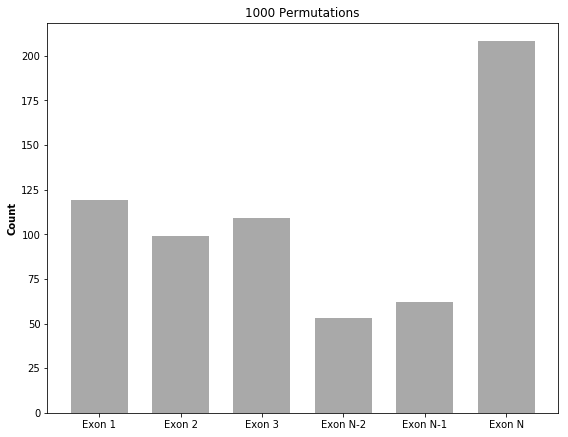

In [367]:
perm_e1 = int(np.mean(perm_exon1))
perm_e2 = int(np.mean(perm_exon2))
perm_e3 = int(np.mean(perm_exon3)) 
perm_n2 = int(np.mean(perm_n2))
perm_n1 = int(np.mean(perm_n1))
perm_n = int(np.mean(perm_n))

print('exon 1, exon 2, exon 3, n-2, n-1, n')
print(np.mean(perm_exon1),np.mean(perm_exon2),np.mean(perm_exon3),np.mean(perm_n2),np.mean(perm_n1),np.mean(perm_n))

xs = ['Exon 1','Exon 2','Exon 3','Exon N-2','Exon N-1','Exon N']
#ys = [int(np.mean(perm_exon1)),int(np.mean(perm_exon2)),int(np.mean(perm_exon3)),int(np.mean(perm_n2)),int(np.mean(perm_n1)),int(np.mean(n))]
ys = [perm_e1, perm_e2, perm_e3, perm_n2, perm_n1, perm_n]
pos = [0,1,2,3,4,5]
#labels = xs

#fig, ax = plt.subplots()
plt.figure(figsize=(8, 6))  # width:20, height:3

names, ticks = [], []
for p in range(0,len(pos)):
    l = xs[p]
    _ = plt.bar(p,int(ys[p]),width = 0.7,align='center',color='darkgrey',label=l)
    names.append(xs[p])
    ticks.append(p)

_ =plt.xticks(ticks,names,fontsize=10)
#_ = plt.title('Exon Count for gene models intersecting novel ROI',fontweight='bold')
_ = plt.ylabel('Count',fontweight='bold')
plt.tight_layout()
plt.title('1000 Permutations')
plt.savefig(permDir + 'plots/Permutations_exonposition.pdf')
plt.show()

In [222]:
    for e in exonID:
        exonNumIntersecting = int(e.split('.exon')[1])
    
    #Now store positional information for each exon
    #If the exon is the first exon, simple, store it in key == 1
    if exonNumIntersecting <= 3:
        if exonNumIntersecting not in intersectingExonNumberDict2.keys():
            intersectingExonNumberDict2[exonNumIntersecting] = []
        intersectingExonNumberDict2[exonNumIntersecting].append([exonID,exonMax])
        continue
    
    else:
        #Distance from the end
        distanceFromLastExon = exonMax - exonNumIntersecting
        if distanceFromLastExon == 0:
            exonNumIntersecting = 'N'
        if distanceFromLastExon == 1:
            exonNumIntersecting = 'N-1'  
        if distanceFromLastExon == 2:
            exonNumIntersecting = 'N-2'
        if distanceFromLastExon > 2:
            exonNumIntersecting = 'Middle Exon'
        if exonNumIntersecting not in intersectingExonNumberDict2.keys():
            intersectingExonNumberDict2[exonNumIntersecting] = []
        intersectingExonNumberDict2[exonNumIntersecting].append([exonID,exonMax])
print('%i gene models that intersect with novel regions dont qualify (less than three exons)' % dontQualify)        
  
    
countArray2 = []
for count in intersectingExonNumberDict2.keys():
    if 'Middle' not in str(count):
        countArray2.append(['Exon ' + str(count),len(intersectingExonNumberDict2[count])])
    else:
        
        countArray2.append([str(count),len(intersectingExonNumberDict2[count])])
        
print(countArray2)
        

{1: [['Gene.4153::chr1.g10386.i1::g.4153::m.4153', 418, 1],
  ['Gene.30004::chr1.g11343.i1::g.30004::m.30004', 702, 1],
  ['Gene.33352::chr1.g11358.i1::g.33352::m.33352', 2734, 1],
  ['Gene.33352::chr1.g11358.i1::g.33352::m.33352', 2734, 1],
  ['Gene.33315::chr1.g11614.i1::g.33315::m.33315', 1316, 1],
  ['Gene.4381::chr1.g11715.i1::g.4381::m.4381', 376, 4],
  ['Gene.27865::chr1.g11790.i1::g.27865::m.27865', 215, 30],
  ['Gene.27865::chr1.g11790.i1::g.27865::m.27865', 215, 30],
  ['Gene.24704::chr1.g1310.i1::g.24704::m.24704', 4629, 1],
  ['Gene.25081::chr1.g13173.i1::g.25081::m.25081', 102, 2],
  ['Gene.950::chr1.g13524.i1::g.950::m.950', 5224, 1],
  ['Gene.950::chr1.g13524.i1::g.950::m.950', 5224, 1],
  ['Gene.781::chr1.g14027.i1::g.781::m.781', 2704, 1],
  ['Gene.31619::chr1.g14037.i1::g.31619::m.31619', 266, 7],
  ['Gene.18775::chr1.g14563.i1::g.18775::m.18775', 809, 21],
  ['Gene.5223::chr1.g14566.i1::g.5223::m.5223', 3037, 1],
  ['Gene.30412::chr1.g14884.i1::g.30412::m.30412', 733

In [229]:
""""def parse_shuffle_intersect(Dict,intersectFile): 
    intersectFile=permDir + 'intersect_zoeygenes_withgaps_0.txt'

    geneLengths = [] #keeping track of gene lengths
    exonNums = []
    genes = []

    #Reading the intersect file results
    for line in open(intersectFile,'r'):
        line = line.rstrip().split('\t') #removing extraneous whitespace characters
        #Example exonID = Gene.23056::chr1.g10665.i1::g.23056::m.23056.exon9, exonNum = 9
        exonID = line[3]
        exonNum = int(exonID.split('.exon')[1])
        geneID = exonID.split('.exon')[0]
        
        #Store globally
        exonNums.append(exonNum)
        genes.append(geneID)
        #Gene length
        geneLength = int(line[2]) - int(line[1])
        geneLengths.append(geneLength)

        if geneID not in Dict.keys():
            Dict[geneID] = {}
            Dict[geneID]['exonMax'] = exonCountDict[geneID]
            Dict[geneID]['intersectingnovelregions'] = []
        Dict[geneID]['intersectingnovelregions'].append(exonID)
            
    return Dict, genes, geneLengths, exonNums

""""

In [353]:
#### SAVE 
"""intersectingExonNumberDict = {}
dontQualify = 0
real_singleExon,real_twoExon = 0,0
real_genes, real_geneLengths = [], []

for line in open(intersectOutfile,'r'):
    line = line.rstrip().split('\t')
    
    #Determine what the max number of exons for this gene is
    geneID = line[7].split('.exon')[0]
    exonMax = exonCountDict[geneID]
    
    ### TOTAL INTERSECTS ###
    real_total_exonIntersectCounts = count_lines(intersectOutfile)

    
    ### GENE LENGTH ###
    geneLength = lengthDict[geneID]
    if geneID not in genes: #Only append if it hasn't already been counted
        genes.append(geneID)
        real_geneLengths.append(geneLength)
    
    #Skip single and double exon genes
    if exonMax == 1:
        real_singleExon+=1
        dontQualify +=1
        continue
    if exonMax == 2:
        real_twoExon+=1
        dontQualify +=1
        continue
    
    #Get which exon intersected with the novel region from the bedfile
    exonNumIntersecting = int(line[7].split('.exon')[1])
    
    #Now store positional information for each exon
    #If the exon is the first exon, simple, store it in key == 1
    if exonNumIntersecting <= 3:
        if exonNumIntersecting not in intersectingExonNumberDict.keys():
            intersectingExonNumberDict[exonNumIntersecting] = []
        intersectingExonNumberDict[exonNumIntersecting].append([line[7],exonMax])
        continue
    
    else:
        #Distance from the end
        distanceFromLastExon = exonMax - exonNumIntersecting
        if distanceFromLastExon == 0:
            exonNumIntersecting = 'N'
        if distanceFromLastExon == 1:
            exonNumIntersecting = 'N-1'  
        if distanceFromLastExon == 2:
            exonNumIntersecting = 'N-2'
        if distanceFromLastExon > 2:
            exonNumIntersecting = 'Middle Exon'
        if exonNumIntersecting not in intersectingExonNumberDict.keys():
            intersectingExonNumberDict[exonNumIntersecting] = []
        intersectingExonNumberDict[exonNumIntersecting].append([line[7],exonMax])
    
countArray = []
for count in intersectingExonNumberDict.keys():
    if 'Middle' not in str(count):
        countArray.append(['Exon ' + str(count),len(intersectingExonNumberDict[count])])
    else:
        
        countArray.append([str(count),len(intersectingExonNumberDict[count])])
        
print(countArray) 

print('%i gene models that intersect with novel regions dont qualify (less than three exons)' % dontQualify)        
print('Real single exons = ', real_singleExon)
real_singleExon = real_singleExon/float(real_total_exonIntersectCounts)
print('    as a proportion of total intersecting exons = ', real_si)

print('Real two exons = ', real_twoExon)
real_twoExon = real_twoExon/float(real_total_exonIntersectCounts)
print('    as a proportion of total intersecting exons = ', real_twoExon )


real_avg_genelength = np.mean(real_geneLengths)
print('\nAverage REAL gene length = ', np.mean(real_avg_genelength))
    """

[['Exon 1', 2255], ['Exon 2', 280], ['Exon 3', 168], ['Exon N', 272], ['Middle Exon', 474], ['Exon N-2', 81], ['Exon N-1', 102]]
1704 gene models that intersect with novel regions dont qualify (less than three exons)
Real single exons =  1352
    as a proportion of total intersecting exons =  0.25337331334332835
Real two exons =  352
    as a proportion of total intersecting exons =  0.06596701649175413

Average REAL gene length =  37443.9519024


4


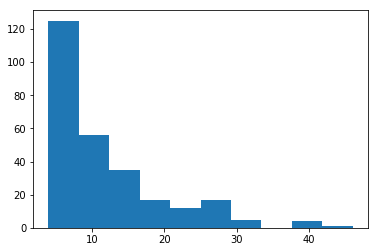

In [160]:
l=[]
for key in intersectingExonNumberDict.keys():
    if 'N' == key:
        for e in intersectingExonNumberDict[key]:
            l.append(e[1])
plt.hist(l)
print(min(l))